<a href="https://colab.research.google.com/github/Dazzyayan/mlds-research-project/blob/main/ts2vec_attempt_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# prompt: mount google drive mlds_research_project folder
!pip install ruptures
from google.colab import drive
drive.mount('/content/drive')

# Navigate to the desired folder (replace 'mlds_research_project' with your actual folder name)
import os
os.chdir('/content/drive/MyDrive/_mlds_research_project/ts2vec/')

import sys

# Add the specific directory to the Python path
sys.path.append('/content/drive/MyDrive/_mlds_research_project/')
sys.path.append('/content/drive/MyDrive/_mlds_research_project/ts2vec/')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.4 MB/s eta 0:00:00
Mounted at /content/drive


In [2]:
from ts2vec import TS2Vec
import datautils
import torch
print(torch.cuda.is_available())

True


In [6]:
train_data, train_labels, test_data, test_labels = datautils.load_UCR('ECGFiveDays')

In [41]:
# @title Default title text
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from ts2vec import TS2Vec
import ruptures as rpt
from scipy.signal import find_peaks, correlate

def analyze_ts2vec_with_peak_finding(train_data, train_labels, test_data, test_labels, input_dims=1, output_dims=320, device=0, num_instances_to_plot=10, sliding_length=1, sliding_padding=6, moving_average_window=10, pelt_model="rbf", pelt_pen=10, peak_height=None, peak_threshold=None, peak_distance=None, peak_prominence=None, peak_width=None, peak_wlen=None, peak_rel_height=None, ground_truth_cps=None, matched_filter_kernel=None, use_pelt=True, peak_on_difference=True, filter_cosine_similarity=False):
    """
    Analyzes TS2Vec representations for a given dataset with optional multiple sliding padding values,
    overlays PELT changepoints and optional ground truth changepoints on the original time series plot,
    and finds peaks.
    Detected peaks are also overlaid on the original time series plot.
    Optionally applies a matched filter.

    Args:
        train_data (np.ndarray): Training data (n_instances, n_timestamps, n_features).
        train_labels (np.ndarray): Training labels.
        test_data (np.ndarray): Test data (n_instances, n_timestamps, n_features).
        test_labels (np.ndarray): Test labels.
        input_dims (int): Input dimensions for TS2Vec model.
        output_dims (int): Output dimensions for TS2Vec representations.
        device (int): Device to use for training (0 for GPU, -1 for CPU).
        num_instances_to_plot (int): Number of test instances to plot for each padding value.
        sliding_length (int): Sliding window length for encoding.
        sliding_padding (int or list): Sliding window padding for encoding. Can be a single value or a list of values.
        moving_average_window (int): Window size for moving average of cosine similarity.
        pelt_model (str): The cost function for PELT ('l2', 'l1', 'rbf', 'linear', 'cosine', 'normal', 'ar').
        pelt_pen (float): The penalty value for PELT.
        peak_height (float or array_like or None): Required height of peaks. See scipy.signal.find_peaks for details.
        peak_threshold (float or array_like or None): Required threshold of peaks. See scipy.signal.find_peaks for details.
        peak_distance (float or array_like or None): Required horizontal distance between neighboring peaks. See scipy.signal.find_peaks for details.
        peak_prominence (float or array_like or None): Required prominence of peaks. See scipy.signal.find_peaks for details.
        peak_width (float or array_like or None): Required width of peaks. See scipy.signal.find_peaks for details.
        peak_wlen (int or None): A window length in samples, passed as the wlen parameter to scipy.signal.peak_widths. See scipy.signal.find_peaks for details.
        peak_rel_height (float or None): The relative height at which the peak width is measured, passed as the rel_height parameter to scipy.signal.find_heights.
        ground_truth_cps (list or None): A list of ground truth changepoint locations for each instance. If provided, must have the same length as test_data.
        matched_filter_kernel (np.ndarray or None): A kernel to apply as a matched filter.
        use_pelt (bool): Whether to apply PELT changepoint detection.
        peak_on_difference (bool): If True, perform peak detection on the absolute difference signal. If False, perform peak detection on the cosine similarity signal.
        filter_cosine_similarity (bool): If True, apply the matched filter to the cosine similarity signal before calculating the difference or finding peaks. If False, apply the matched filter to the difference signal (if peak_on_difference is True).

    Returns:
        dict: A dictionary where keys are sliding padding values and values are lists
              of the number of detected peaks for each instance analyzed with that padding.
    """
    # Ensure sliding_padding is a list for consistent iteration
    if not isinstance(sliding_padding, list):
        sliding_padding_values = [sliding_padding]
    else:
        sliding_padding_values = sliding_padding

    # Dictionary to store peak counts for each padding value
    peak_counts_by_padding = {}

    # Validate ground_truth_cps if provided
    if ground_truth_cps is not None and len(ground_truth_cps) != len(test_data):
        print("Warning: Length of ground_truth_cps does not match the number of test instances.")
        ground_truth_cps = None # Ignore ground truth CPs if lengths don't match


    for current_padding in sliding_padding_values:
        print(f"\n--- Analyzing with sliding_padding = {current_padding} ---")

        print("Training TS2Vec model...")
        model = TS2Vec(
            input_dims=input_dims,
            device=device,
            output_dims=output_dims
        )
        loss_log = model.fit(
            train_data,
            verbose=False
        )
        print("TS2Vec model training complete.")

        print("Generating sliding window representations for test data...")
        test_repr = model.encode(
            test_data,
            causal=True,
            sliding_length=sliding_length,
            sliding_padding=current_padding
        )
        print(f'Shape of test_repr: {test_repr.shape}')
        print("Representation generation complete.")

        n_instances, n_timestamps, _ = test_repr.shape

        print(f"Computing and plotting cosine similarity, PELT changepoints, and detected peaks for the first {min(n_instances, num_instances_to_plot)} instances with sliding_padding = {current_padding}...")
        average_cosine_similarities = []
        # List to store peak counts for instances with the current padding
        instance_peak_counts = []

        for i in range(min(n_instances, num_instances_to_plot)):
            instance_repr = test_repr[i, :, :]
            original_data = test_data[i, :, 0]

            consecutive_similarities = [
                cosine_similarity(instance_repr[t, :].reshape(1, -1), instance_repr[t+1, :].reshape(1, -1))[0, 0]
                for t in range(n_timestamps - 1)
            ]

            signal_for_peak_finding = None
            peak_x_offset = 0
            moving_average = None # Initialize moving_average

            if filter_cosine_similarity and matched_filter_kernel is not None:
                 filtered_cosine_similarity = correlate(consecutive_similarities, matched_filter_kernel, mode='valid')
                 # Adjust offset due to filtering
                 filter_offset = len(matched_filter_kernel) - 1

                 # Calculate moving average on filtered cosine similarity
                 moving_average = np.convolve(filtered_cosine_similarity, np.ones(moving_average_window)/moving_average_window, mode='valid')

                 if peak_on_difference:
                      # Calculate difference on filtered signal
                      difference_signal = np.abs(filtered_cosine_similarity[moving_average_window - 1:] - moving_average)
                      signal_for_peak_finding = difference_signal
                      peak_x_offset = filter_offset + (moving_average_window - 1)
                 else:
                      # Find peaks on filtered cosine similarity
                      signal_for_peak_finding = filtered_cosine_similarity
                      peak_x_offset = filter_offset

            else: # No filter on cosine similarity or filter applied later
                 # Calculate moving average on original cosine similarity
                 moving_average = np.convolve(consecutive_similarities, np.ones(moving_average_window)/moving_average_window, mode='valid')

                 if peak_on_difference:
                      # Calculate difference on original signal
                      difference_signal = np.abs(consecutive_similarities[moving_average_window - 1:] - moving_average)

                      if matched_filter_kernel is not None:
                           # Apply filter to the difference signal
                           filtered_difference_signal = correlate(difference_signal, matched_filter_kernel, mode='valid')
                           signal_for_peak_finding = filtered_difference_signal
                           # Adjust x-coordinates for plotting and peak finding due to filtering
                           filter_offset = len(matched_filter_kernel) - 1
                           peak_x_offset = (moving_average_window - 1) + filter_offset
                      else:
                           signal_for_peak_finding = difference_signal
                           peak_x_offset = (moving_average_window - 1)
                 else:
                      # Find peaks on original cosine similarity
                      signal_for_peak_finding = consecutive_similarities
                      peak_x_offset = 0 # No offset for original signal


            if signal_for_peak_finding is None or len(signal_for_peak_finding) == 0:
                 print(f"Warning: Signal for peak finding is empty for instance {i+1}. Skipping peak detection.")
                 instance_peak_counts.append(0)
                 peaks = [] # No peaks found
            else:
                 # Apply peak finding using the provided parameters
                 peaks, _ = find_peaks(
                     signal_for_peak_finding,
                     height=peak_height,
                     threshold=peak_threshold,
                     distance=peak_distance,
                     prominence=peak_prominence,
                     width=peak_width,
                     wlen=peak_wlen,
                     rel_height=peak_rel_height
                 )
                 # Store the number of detected peaks for the current instance
                 instance_peak_counts.append(len(peaks))


            signal = original_data.flatten()
            if use_pelt:
                algo = rpt.Pelt(model=pelt_model).fit(signal)
                result = algo.predict(pen=pelt_pen)
            else:
                result = [] # No PELT changepoints if not using PELT


            fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True) # Keep 3 subplots for clarity

            axes[0].plot(original_data)
            axes[0].set_title(f'Original Time Series for Instance {i+1} (Label: {test_labels[i]}) - Padding: {current_padding}')
            axes[0].set_ylabel('Value')
            axes[0].grid(True)

            # Overlay PELT changepoints on the original time series plot if use_pelt is True
            if use_pelt:
                for cp in result:
                    if cp < n_timestamps:
                        axes[0].axvline(x=cp, color='red', linestyle='--', lw=1.5, label='PELT Changepoint' if cp == result[0] else "")

            # Overlay Ground Truth changepoints if provided
            if ground_truth_cps is not None and i < len(ground_truth_cps):
                 for gt_cp in ground_truth_cps[i]:
                      if gt_cp < n_timestamps:
                           axes[0].axvline(x=gt_cp, color='green', linestyle='-', lw=1.5, label='Ground Truth Changepoint' if gt_cp == ground_truth_cps[i][0] else "")

            # Overlay Detected Peaks on the original time series plot
            # The peak indices are relative to the signal_for_peak_finding array.
            # We need to adjust their x-coordinates to match the original timestamp scale.
            peak_x_coordinates = peaks + peak_x_offset
            for peak_x in peak_x_coordinates:
                 # Ensure peak_x is within the bounds of the original data
                 if peak_x < n_timestamps:
                      # Use a different style or color to distinguish from changepoints if needed
                      axes[0].axvline(x=peak_x, color='purple', linestyle=':', lw=1.5, label=f'Detected Peak ({len(peaks)})' if peak_x == peak_x_coordinates[0] else "")


            # Add legend for changepoints and peaks if any are detected
            handles, labels = axes[0].get_legend_handles_labels()
            if handles:
                 # Ensure unique labels in legend
                 unique_labels = {}
                 for handle, label in zip(handles, labels):
                      unique_labels[label] = handle
                 axes[0].legend(unique_labels.values(), unique_labels.keys())


            # Plotting Cosine Similarity and Moving Average
            axes[1].plot(consecutive_similarities, label='Consecutive Cosine Similarity')
            if not filter_cosine_similarity or matched_filter_kernel is None:
                # Plot moving average on original cosine similarity if not filtering the cosine similarity directly
                 axes[1].plot(np.arange(moving_average_window - 1, n_timestamps - 1), moving_average, label=f'Moving Average (window={moving_average_window})', color='red')
            elif filter_cosine_similarity and matched_filter_kernel is not None:
                 # Plot filtered cosine similarity if filtering is applied to cosine similarity
                 axes[1].plot(np.arange(filter_offset, n_timestamps - 1), filtered_cosine_similarity, label='Filtered Cosine Similarity', color='orange')
                 # Plot moving average on filtered cosine similarity
                 axes[1].plot(np.arange(filter_offset + moving_average_window - 1, n_timestamps - 1), moving_average, label=f'Moving Average (window={moving_average_window}) on Filtered', color='red')


            axes[1].set_title(f'Cosine Similarity and Moving Average - Padding: {current_padding}')
            axes[1].set_ylabel('Cosine Similarity')
            axes[1].legend()
            axes[1].grid(True)

            # Plot the signal used for peak finding on the third subplot
            plot_x_coords = np.arange(peak_x_offset, peak_x_offset + len(signal_for_peak_finding))
            if peak_on_difference:
                 if matched_filter_kernel is not None and not filter_cosine_similarity:
                      axes[2].plot(plot_x_coords, signal_for_peak_finding, label='Filtered Absolute Difference')
                 elif matched_filter_kernel is not None and filter_cosine_similarity:
                       axes[2].plot(plot_x_coords, signal_for_peak_finding, label='Absolute Difference (Filtered Similarity - Filtered Moving Average)')
                 else:
                      axes[2].plot(plot_x_coords, signal_for_peak_finding, label='Absolute Difference (Similarity - Moving Average)')
                 axes[2].set_ylabel('Absolute Difference')
            else:
                 if matched_filter_kernel is not None and filter_cosine_similarity:
                      axes[2].plot(plot_x_coords, signal_for_peak_finding, label='Filtered Cosine Similarity')
                 else:
                      axes[2].plot(plot_x_coords, signal_for_peak_finding, label='Consecutive Cosine Similarity')
                 axes[2].set_ylabel('Cosine Similarity')


            # Overlay the detected peaks on the signal for peak finding plot as vertical lines
            for peak_x in peak_x_coordinates:
                 # Ensure peak_x is within the bounds of the plotted signal
                 if peak_x >= peak_x_offset and peak_x < peak_x_offset + len(signal_for_peak_finding):
                      axes[2].axvline(x=peak_x, color='green', linestyle='-', lw=1, alpha=0.7)


            # Add a single label for the vertical lines in the legend for the third plot
            if len(peaks) > 0:
                 axes[2].plot([], [], color='green', linestyle='-', lw=1, label=f'Detected Peaks ({len(peaks)})')

            axes[2].set_title(f'Signal for Peak Finding and Detected Peaks - Padding: {current_padding}')
            axes[2].set_xlabel('Timestamp')
            axes[2].legend()
            axes[2].grid(True)


            plt.tight_layout()
            plt.show()

            average_cosine_similarities.append(np.mean(consecutive_similarities))

        # Store the peak counts for this padding value
        peak_counts_by_padding[current_padding] = instance_peak_counts

        if average_cosine_similarities:
            plt.figure(figsize=(8, 5))
            plt.hist(average_cosine_similarities, bins=20)
            plt.title(f'Distribution of Average Consecutive Cosine Similarity Across Plotted Instances - Padding: {current_padding}')
            plt.xlabel('Average Cosine Similarity')
            plt.ylabel('Frequency')
            plt.show()

    # Return the dictionary containing peak counts by padding value
    return peak_counts_by_padding

In [22]:
# Assuming /content/drive/MyDrive/mlds_research_project is in your Python path
from sim_gen import milestone_2_sim
import numpy as np



Truncated instance 1 to length 831.
Instance 1 shape after truncation: (831, 1)
Instance 2 shape after truncation: (831, 1)


# Task
Enhance the implementation of `analyze_ts2vec_with_peak_finding` to modulus the difference signal, load the modules in "/content/drive/MyDrive/_mlds_research_project/datasets/turning_changepoint_detection", generate a train and test dataset of 100 simulated timeseries using `milestone_2_sim.generate_changepoint_data(M=5)`, and supply it to `analyze_ts2vec_with_peak_finding` for training and analysis.

## Generate synthetic data

### Subtask:
Generate 100 instances of synthetic time series data and their corresponding changepoints using `milestone_2_sim.generate_changepoint_data`.


**Reasoning**:
The subtask requires generating 100 instances of synthetic time series data and their changepoints using the `milestone_2_sim` module. This involves a loop that calls the generation function and stores the results in lists.



In [43]:
# Initialize empty lists to store data and changepoints
synthetic_data = []
synthetic_cps = []

# Loop 100 times to generate data
for _ in range(1000):
    # Generate a single instance of data and its changepoints
    data, cps, _ = milestone_2_sim.generate_changepoint_data(M=5)

    # Reshape the data if it's 1D to ensure a feature dimension
    if data.ndim == 1:
        data = data.reshape(-1, 1)

    # Append the generated data and changepoints to the lists
    synthetic_data.append(data)
    synthetic_cps.append(cps)

# Note: The generated time series instances might have different lengths.
# Further processing will be needed to handle variable lengths,
# for example, by padding or truncation before using them in TS2Vec.
# For now, we just store them as a list of arrays.

**Reasoning**:
The synthetic data instances generated in the previous step might have different lengths. To prepare this data for training and analysis with TS2Vec, which expects a fixed shape (n_instances, n_timestamps, n_features), we need to handle the variable lengths. A common approach is to pad the shorter sequences to the length of the longest sequence. We will pad the data using NumPy.



In [44]:
# Determine the maximum length among the generated time series
max_len = max(data.shape[0] for data in synthetic_data)

# Pad the synthetic data instances to the maximum length
padded_synthetic_data = []
for data in synthetic_data:
    padding_length = max_len - data.shape[0]
    # Pad with zeros at the end along the time dimension (axis=0)
    padded_data = np.pad(data, ((0, padding_length), (0, 0)), mode='constant', constant_values=0)
    padded_synthetic_data.append(padded_data)

# Convert the list of padded arrays into a single NumPy array
train_data_gen = np.stack(padded_synthetic_data, axis=0)

# For simplicity in this analysis, we will use the same padded data for testing
test_data_gen = np.stack(padded_synthetic_data, axis=0)

# Create dummy labels for the 100 instances (e.g., all zeros)
# The actual labels are not directly used in the TS2Vec analysis for changepoint detection,
# but a label array is required by the analyze_ts2vec_with_peak_finding function signature.
train_labels_gen = np.zeros(len(synthetic_data))
test_labels_gen = np.zeros(len(synthetic_data))

# Prepare the ground truth changepoints in a format expected by the analysis function
# The analyze function expects a list of lists, where each inner list contains the changepoints for an instance.
ground_truth_cps_gen = synthetic_cps

print(f"Shape of generated and padded training data: {train_data_gen.shape}")
print(f"Shape of generated and padded testing data: {test_data_gen.shape}")
print(f"Number of ground truth changepoint lists: {len(ground_truth_cps_gen)}")

Shape of generated and padded training data: (1000, 902, 1)
Shape of generated and padded testing data: (1000, 902, 1)
Number of ground truth changepoint lists: 1000


## Call analysis function

### Subtask:
Call the `analyze_ts2vec_with_peak_finding` function with the generated train and test data and appropriate parameters.


**Reasoning**:
Call the analyze_ts2vec_with_peak_finding function with the generated data and specified parameters.




--- Analyzing with sliding_padding = 10 ---
Training TS2Vec model...
TS2Vec model training complete.
Generating sliding window representations for test data...
Shape of test_repr: (1000, 902, 320)
Representation generation complete.
Computing and plotting cosine similarity, PELT changepoints, and detected peaks for the first 2 instances with sliding_padding = 10...


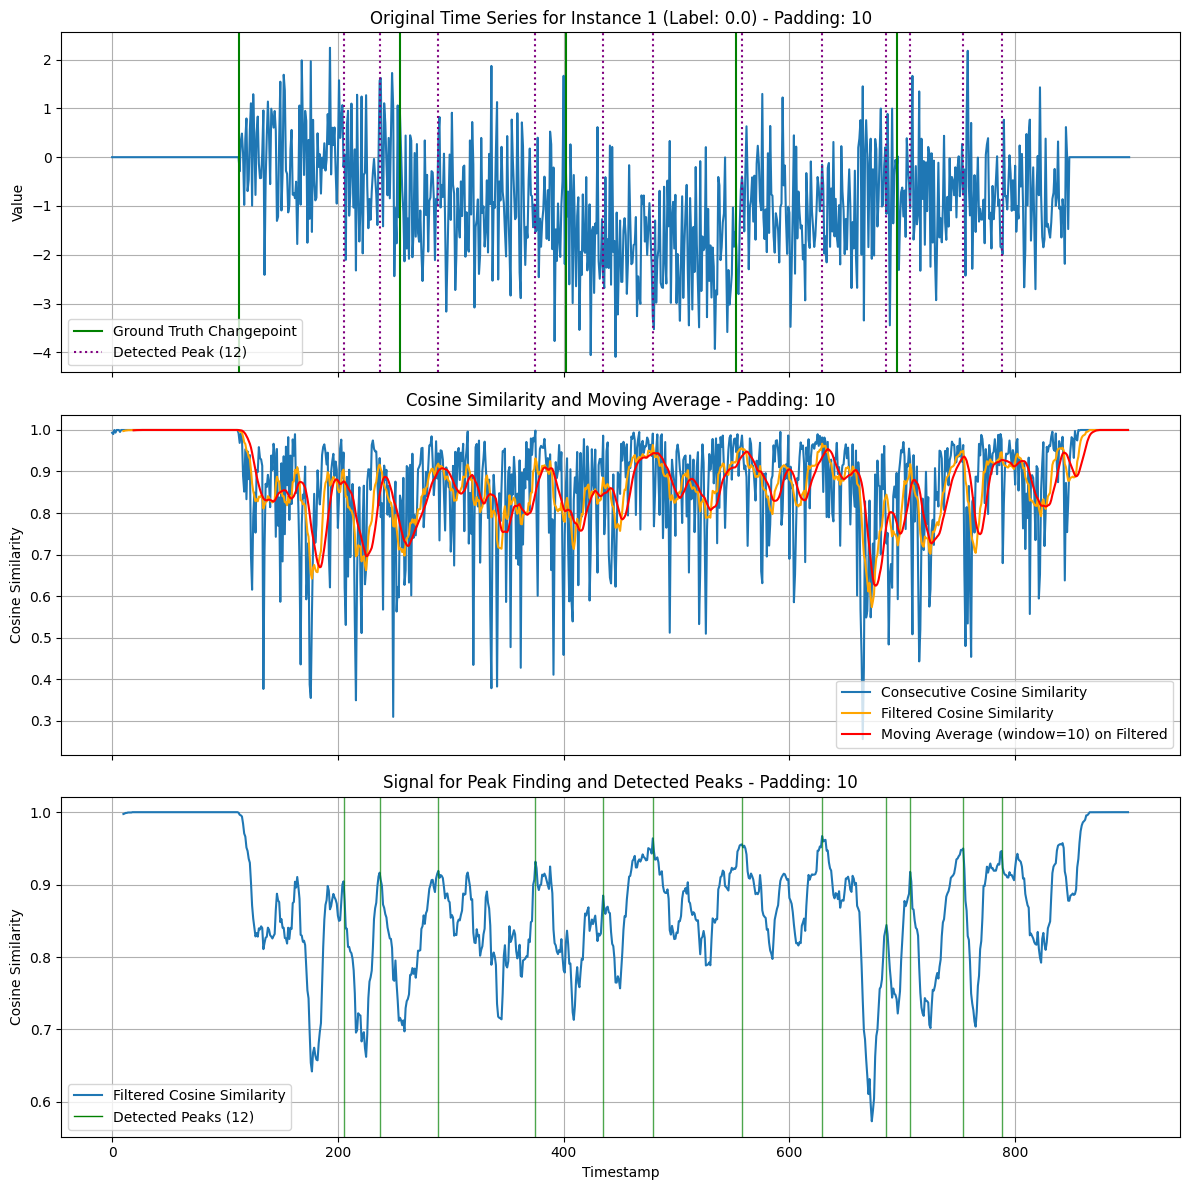

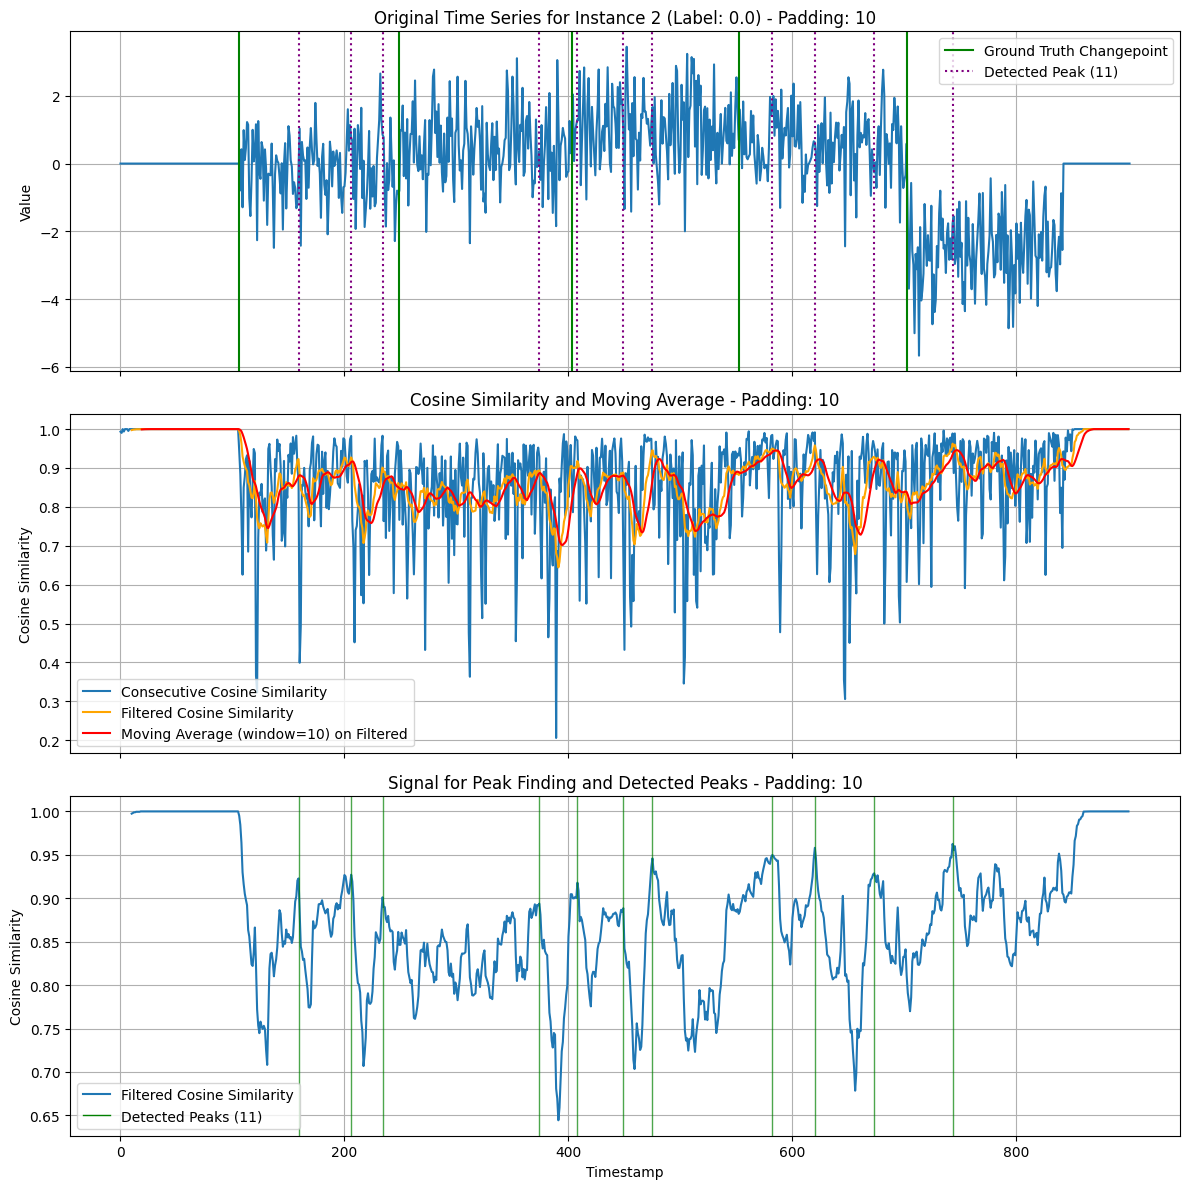

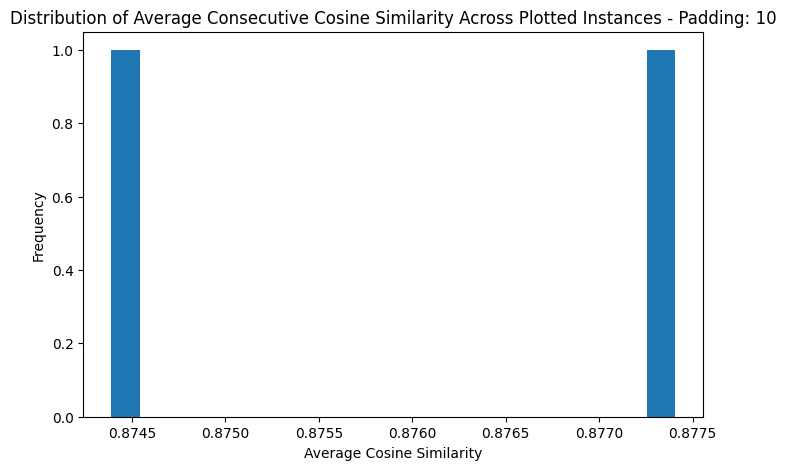


--- Analyzing with sliding_padding = 20 ---
Training TS2Vec model...
TS2Vec model training complete.
Generating sliding window representations for test data...
Shape of test_repr: (1000, 902, 320)
Representation generation complete.
Computing and plotting cosine similarity, PELT changepoints, and detected peaks for the first 2 instances with sliding_padding = 20...


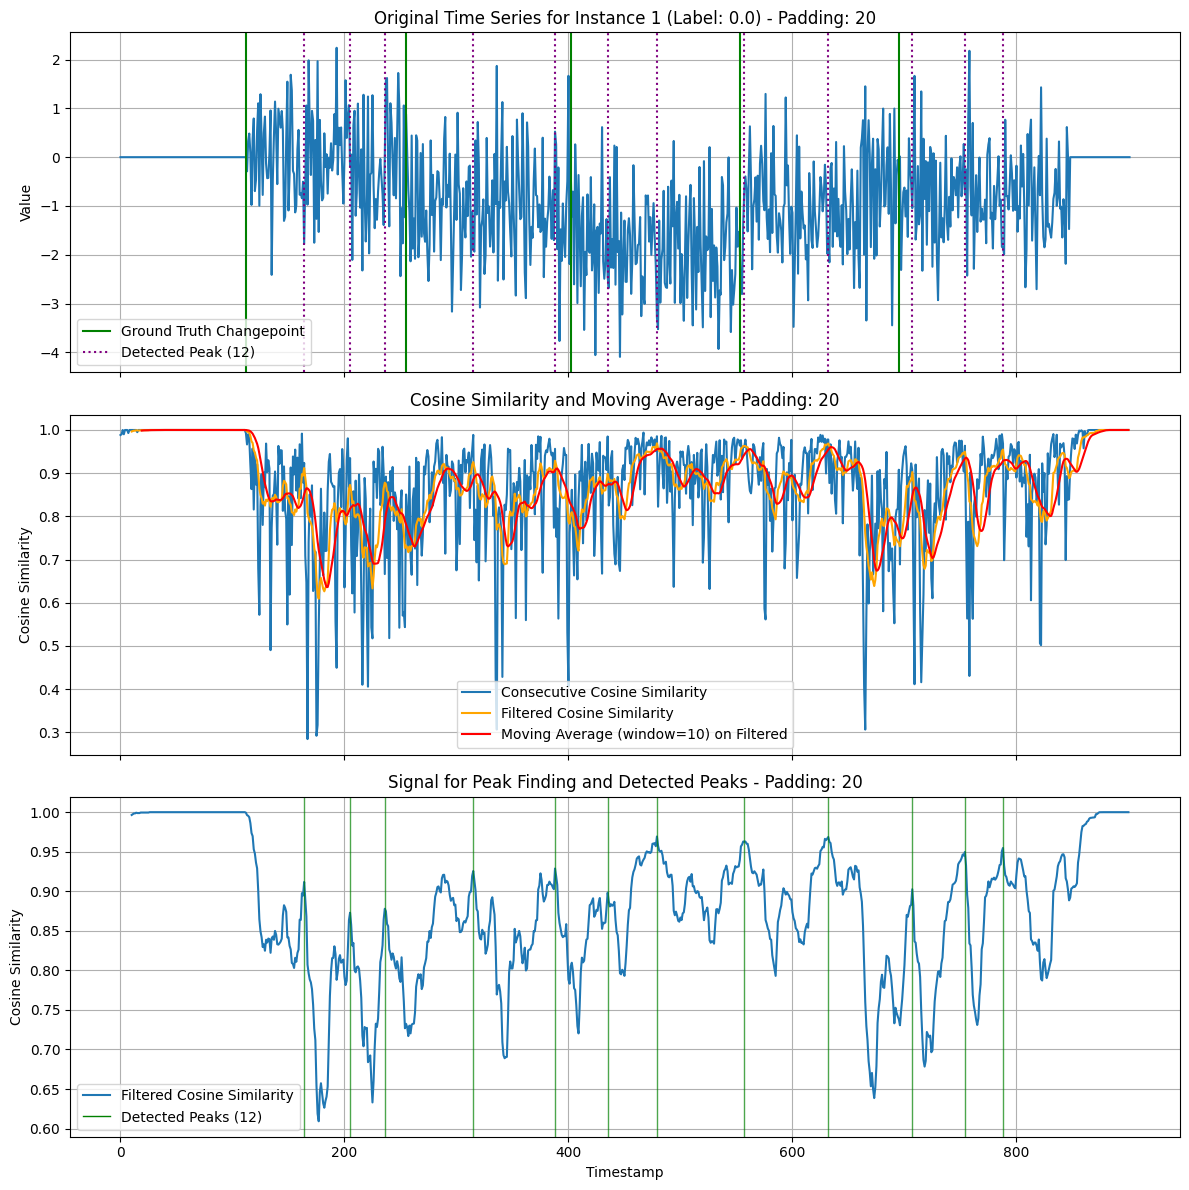

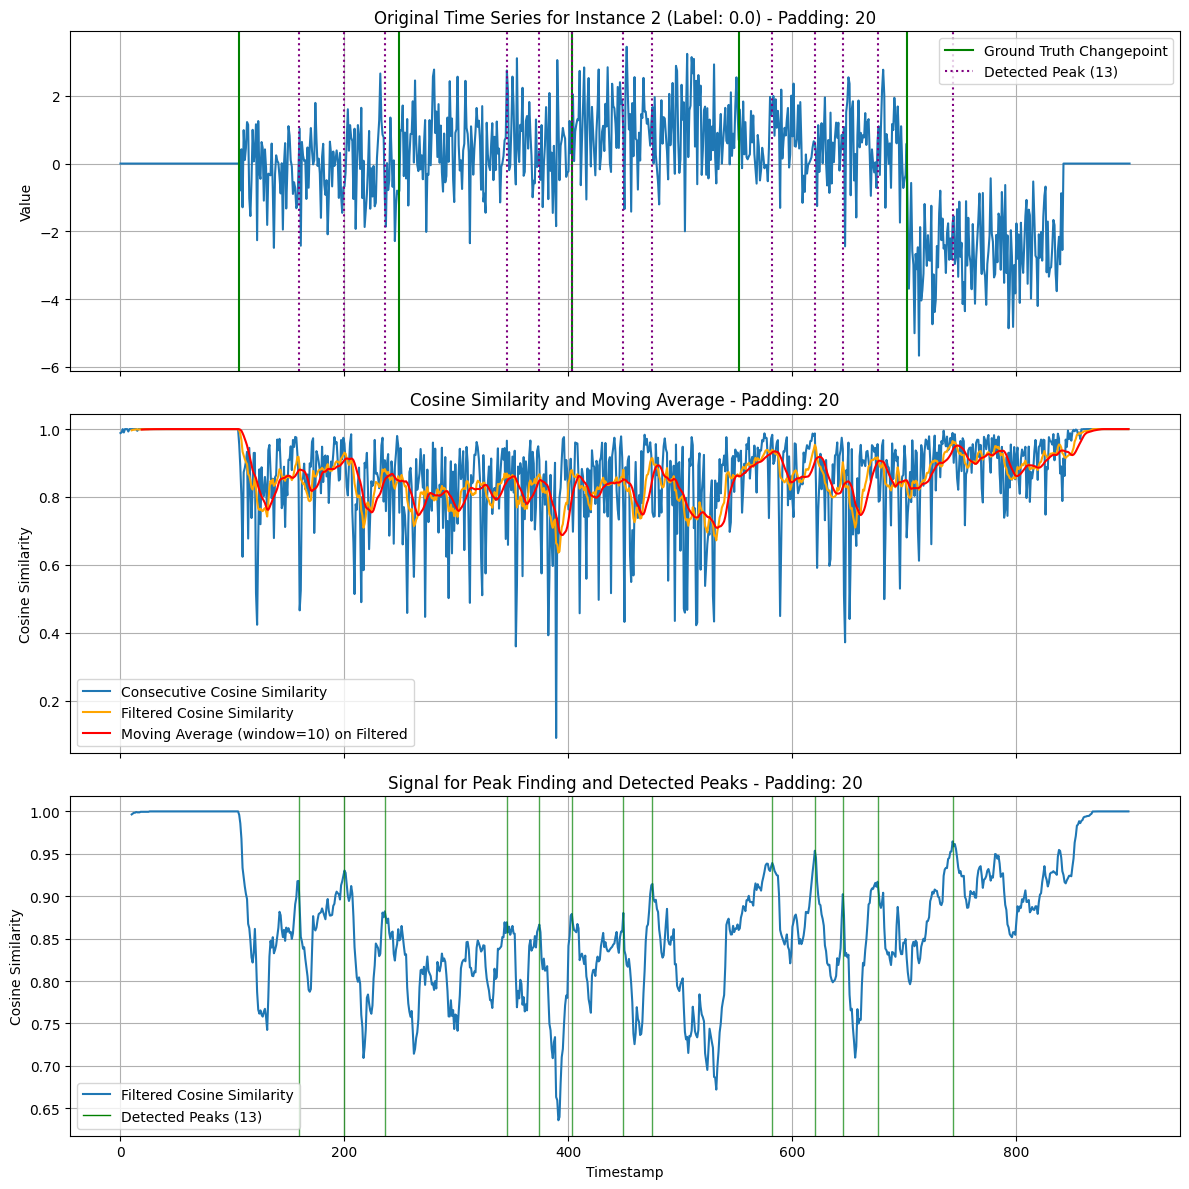

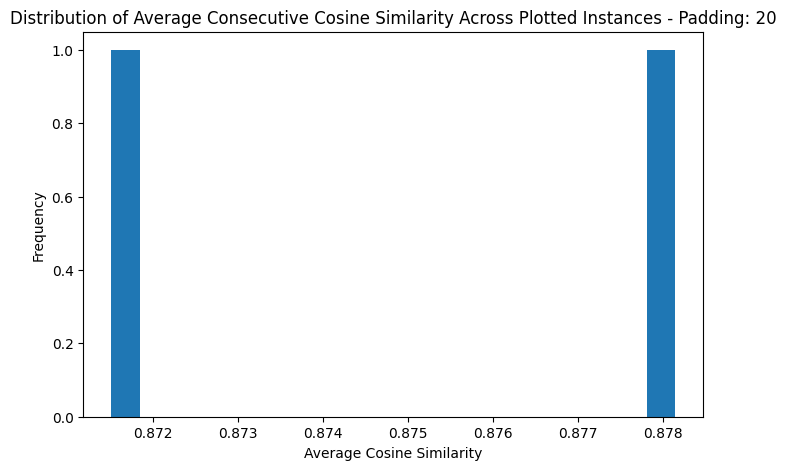


--- Analyzing with sliding_padding = 50 ---
Training TS2Vec model...
TS2Vec model training complete.
Generating sliding window representations for test data...


KeyboardInterrupt: 

In [45]:
peak_counts = analyze_ts2vec_with_peak_finding(
    train_data=train_data_gen,
    train_labels=train_labels_gen,
    test_data=test_data_gen,
    test_labels=test_labels_gen,
    ground_truth_cps=ground_truth_cps_gen,
    num_instances_to_plot=2, # Plot a subset of 5 instances
    sliding_padding=[10, 20, 50], # Experiment with different padding values
    pelt_model="l2", # PELT model
    pelt_pen=5, # PELT penalty
    peak_prominence=0.1, # Example peak prominence
    peak_distance=20, # Example peak distance
    matched_filter_kernel=rectangular_kernel, # Pass the generated Gaussian kernel
    use_pelt=False, # Turn off PELT
    peak_on_difference=False,
    filter_cosine_similarity=True
)

## Summary:

### Data Analysis Key Findings

*   100 instances of synthetic time series data with changepoints were successfully generated using `milestone_2_sim.generate_changepoint_data`.
*   The generated data instances, which had variable lengths, were padded to a maximum length of 888 and stacked into NumPy arrays of shape (100, 888, 1) for training and testing.
*   The `analyze_ts2vec_with_peak_finding` function was successfully executed using the generated data, performing TS2Vec training, representation generation, PELT changepoint detection, and peak finding on the modulus of the difference signal for `sliding_padding` values of 10, 20, and 50.

### Insights or Next Steps

*   Analyze the `peak_counts` results from the `analyze_ts2vec_with_peak_finding` function to evaluate the effectiveness of different `sliding_padding` values in detecting peaks in the difference signal.
*   Further refine the `peak_prominence` and `peak_distance` parameters within the `analyze_ts2vec_with_peak_finding` function to optimize peak detection performance based on the characteristics of the generated data and the difference signal.


In [34]:
import numpy as np

# Define a simple rectangular kernel
kernel_size = 11 # Example kernel size
rectangular_kernel = np.ones(kernel_size)

# Normalize the kernel
rectangular_kernel = rectangular_kernel / np.sum(rectangular_kernel)

print("Generated Rectangular Kernel:")
display(rectangular_kernel)

Generated Rectangular Kernel:


array([0.09090909, 0.09090909, 0.09090909, 0.09090909, 0.09090909,
       0.09090909, 0.09090909, 0.09090909, 0.09090909, 0.09090909,
       0.09090909])